In [1]:
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf


tf.random.set_seed(66) #재현을 위한 텐서플로우 seed 설정

data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
print(data_train.shape)
data_train.head()

(2335, 34)


,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


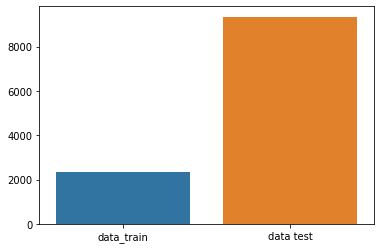

In [2]:
x = ["data_train", "data test"]
y = [data_train.shape[0], data_test.shape[0]]
ax = sns.barplot(x=x, y=y)

In [3]:
train_X = data_train.drop(['target', 'id'], axis = 1)
train_X = (train_X+130)/260 
train_X = np.array(train_X)
train_X = np.array(train_X).reshape(-1, 8, 4, 1)

train_Y = data_train['target']
train_Y = np.array(train_Y)

X_test = data_test.drop('id', axis = 1)
X_test = (X_test+130)/260
X_test = np.array(X_test).reshape(-1, 8, 4, 1)

In [4]:
print("min :", train_X.min(), "\nmax :", train_X.max())

min : 0.008470580769230742 
max : 0.9890809815384616


In [5]:
train_X.shape

(2335, 8, 4, 1)

In [6]:
train_Y.shape

(2335,)

In [7]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [8]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [9]:
def CustomModel(input_shape = (8, 4, 1), classes = 4):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2)) #(3,3) 보다는 직사각형 이미지이기때문에 (3,2)처럼 직사각형 필터를 사용
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = tf.keras.layers.AveragePooling2D(2,2)(X) #Max보다는 Average pool이 성능이 잘나옴

    X = convolutional_block(X, 256, (2,1)) #(2,1) 직사각형 필터를 사용
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X) #Flatten 대신 사용
    
    X = tf.keras.layers.Dense(128, activation = "relu")(X)
    
    X = tf.keras.layers.Dropout(0.5)(X)
    
    X = tf.keras.layers.Dense(classes, activation = "softmax")(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "CustomModel")
    
    return model

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 15, random_state = 66, shuffle = True) #총 15번의 fold 진행
n = 0 #x번째 fold인지 기록

cnn_pred = [] #모델의 예측값 모두 저장

for train_index, valid_index in skf.split(train_X, train_Y):
    n += 1
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]

    ### Swap Noise ###
    X_train_mix = np.array(X_train)
    for x in range(X_train_mix.shape[0]):
        for i in range(5):
            y = np.random.randint(0, 8)
            z = np.random.randint(0, 4)
            
            while True:
                c = np.random.randint(0, X_train_mix.shape[0]-1)
                if ((x != c)and(y_train[x] == y_train[c])):
                    break
                    
            X_train_mix[x][y][z] = X_train[c][y][z]

    X_train = np.append(X_train, X_train_mix, axis = 0)
    y_train = np.append(y_train, y_train, axis = 0)
    
    ### Mix Data Again ####
    X_train, y_train = shuffle(X_train, y_train, random_state=66)
    
    y_train = tf.one_hot(y_train, 4)
    y_train = tf.reshape(y_train, [-1,4])
    y_train = np.array(y_train)
    
    y_valid = tf.one_hot(y_valid, 4)
    y_valid = tf.reshape(y_valid, [-1,4])
    y_valid = np.array(y_valid)
    
    ### Create Model ###
    model = CustomModel()
    
    ### Compile Model ###
    model.compile(optimizer='adam', # 무난한 adam 사용
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ### Create callbacks ###
    filename = 'CNN-checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,             # file명을 지정합니다
                                                    monitor='val_accuracy',   # val_accuracy 값이 개선되었을때 호출됩니다
                                                    verbose=3,            # 로그를 출력합니다 0일경우 출력 X
                                                    save_best_only=True,  # 가장 best 값만 저장합니다
                                                    mode='auto'           # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                                   )
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                  patience=15,         # 12 Epoch동안 개선되지 않는다면 종료
                                 )
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
        factor=0.2, # learning rate이 0.5배 줄어듬
        patience=10, # 6 Epoch동안 개선되지 않는다면 호출
    )
    
    ### fit model ###
    data = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_valid, y_valid), 
                     epochs=1000, 
                     batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                     callbacks=[reduceLR, earlystopping, checkpoint],
                     verbose=3 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                    )
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
                                                                data.history['val_accuracy'][idx], 
                                                                data.history['val_loss'][idx]))
    
    ### predict model ###
    model = tf.keras.models.load_model('./CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴
    pred_proba = model.predict(X_test) # 테스트 셋에 대한 예측 수행
    cnn_pred.append(pred_proba) # 예측값을 cnn_pred 리스트에 저장

Epoch 1/1000

Epoch 00001: val_accuracy improved from -inf to 0.28846, saving model to CNN-checkpoint.h5


C:\ProgramData\Anaconda3\envs\tf270gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/1000

Epoch 00002: val_accuracy improved from 0.28846 to 0.33974, saving model to CNN-checkpoint.h5
Epoch 3/1000

Epoch 00003: val_accuracy improved from 0.33974 to 0.53846, saving model to CNN-checkpoint.h5
Epoch 4/1000

Epoch 00004: val_accuracy improved from 0.53846 to 0.55769, saving model to CNN-checkpoint.h5
Epoch 5/1000

Epoch 00005: val_accuracy improved from 0.55769 to 0.71795, saving model to CNN-checkpoint.h5
Epoch 6/1000

Epoch 00006: val_accuracy did not improve from 0.71795
Epoch 7/1000

Epoch 00007: val_accuracy did not improve from 0.71795
Epoch 8/1000

Epoch 00008: val_accuracy improved from 0.71795 to 0.75000, saving model to CNN-checkpoint.h5
Epoch 9/1000

Epoch 00009: val_accuracy improved from 0.75000 to 0.80128, saving model to CNN-checkpoint.h5
Epoch 10/1000

Epoch 00010: val_accuracy did not improve from 0.80128
Epoch 11/1000

Epoch 00011: val_accuracy did not improve from 0.80128
Epoch 12/1000

Epoch 00012: val_accuracy improved from 0.80128 to 0.84615,

KeyboardInterrupt: 

In [ ]:
pred_proba = cnn_pred[0]
pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1, 15):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

In [ ]:
import pandas as pd

sample_submission = pd.read_csv("./sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit_25.csv",index=False)

In [ ]:
sample_submission.head()